# Combining ionChem with ElSpec
## Goal: run ELSpec, load produced output, run ionChem, feed produced output to ElSpec

In [1]:
direc = '/Users/ost051/Documents/MATLAB/IC/'
a = direc + 'ElSpec_20061212T193031-20061212T193225_beata_uhf_Sergienko_SheehanGr_integrate_5_1_best_20230123T141438.mat'

direc = '/Users/ost051/Documents/PhD/ELSPEC-2022/'
a = direc + 'ElSpec_20061212T193031-20061212T193321_arc1_uhf_Sergienko_SheehanGr_p_integrate_5_best_20230127T182429.mat'

In [2]:
import scipy.io as spio
from scipy.integrate import solve_ivp
from scipy.interpolate import PchipInterpolator
import import_ipynb
import ionChem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


importing Jupyter notebook from ionChem.ipynb
importing Jupyter notebook from organizing.ipynb


In [3]:
mat = loadmat(a)
con = mat["ElSpecOut"]
print(con["iri"].shape)
print(con["h"].shape)
print(con["q"].T.shape)
print(con["ts"].shape)
print(con["te"].shape)

n_model = con["iri"]
[Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model[:, :, 0].T
temp = n_model[:, :3, :].T
ts = con["ts"]
te = con["te"] - ts[0]
ts = ts - ts[0]
e_prod = con["q"].T
print(temp.shape)
print(con["ne"].shape)

(62, 10, 128)
(62,)
(128, 62)
(128,)
(128,)
(128, 3, 62)
(62, 128)


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_55231/1504845631.py:27: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_55231/1504845631.py:38: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


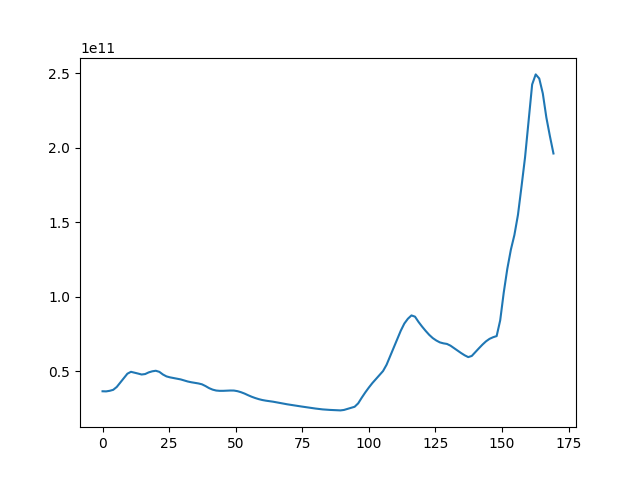

In [4]:
plt.figure()
plt.plot(ts, con["ne"][0, :])

In [5]:
def stepped_prod_t(prod, t):
    """
    returns the production according to the ELSPEC model
    of any species where prod is defined
    at arbitrary times
    using the last ts from ELSPEC
    """
    if t<ts[0]:
        return 0
    if t >te[-1]:
        return 0
    else:
        i_max_ts = len(ts[ts<=t])-1
        prod_t = prod[i_max_ts]
        return prod_t

In [6]:
chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
z_model = con["h"]

model = ionChem.ionChem(chemistry_config, z_model)

#assign densities
model.N2.density  = nN2
model.O2.density  = nO2
model.O.density   = nO
model.NOp.density = nNOp
model.O2p.density = nO2p
model.Op.density  = nOp

model.Np.density  = model.N2.density*0
model.N2p.density = model.N2.density*0
model.N.density   = model.N2.density*0
model.NO.density  = model.N2.density*0

#model.e.density = np.sum([nNOp,nO2p,nOp,model.N2p.density], axis = 0)

model.e.density = con["ne"][:, 0]

model.check_chargeNeutrality()

#assign production (unused?)
for c in model.all_species:
    c.prod = e_prod *0

#model.e.prod   = e_prod
Op_prod  = e_prod * 0.56 * model.O.density  / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
O2p_prod = e_prod * 1.00 * model.O2.density / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
N2p_prod = e_prod * 0.92 * model.N2.density / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)


#create smooth function for production
t = np.arange(0, te[-1], 0.01)

stepf = np.array([stepped_prod_t(e_prod, i) for i in t])
e_prod_smooth = PchipInterpolator(t, stepf)

stepf = np.array([stepped_prod_t(Op_prod, i) for i in t])
Op_prod_smooth = PchipInterpolator(t, stepf)

stepf = np.array([stepped_prod_t(O2p_prod, i) for i in t])
O2p_prod_smooth = PchipInterpolator(t, stepf)

stepf = np.array([stepped_prod_t(N2p_prod, i) for i in t])
N2p_prod_smooth = PchipInterpolator(t, stepf)

#zero function for species that dont feel production 
def zerof(t):
    try:
        some_object_iterator = iter(t)
        return np.zeros(len(t), len(z_model))
    except TypeError as te:
        return np.zeros(len(z_model))

#save production function as array, in order of species
prodMat = np.array([e_prod_smooth, 
                    zerof, 
                    Op_prod_smooth, 
                    zerof, 
                    O2p_prod_smooth, 
                    zerof, 
                    zerof, 
                    zerof, 
                    N2p_prod_smooth, 
                    zerof, 
                    zerof])


#assign temperatures (unused?)
#model.Tn = Tn
#model.Tr = Ti
#model.Te = Te
#print(Tn.shape)
#print(Ti.shape)
#print(Te.shape)
#
#for c in model.all_species:
#    print(c)
#    print(c.name)
#    print(c.density.shape)
#    print(c.prod.shape)

In [11]:
#new way to do ionospheric chemistry
#1. take all info from reaction (reaction rate, constituents)
ode_mat = np.zeros((len(model.all_reactions), len(model.all_species)), dtype = 'object')
rrate = np.array([np.array([r.r_rate_t(*t) for r in model.all_reactions]) for t in temp])


for r in model.all_reactions:
    e = r.educts_ID
    p = r.products_ID
    ode_mat[r.r_ID, e[0]] = np.array([r.r_ID, -1, *e])
    ode_mat[r.r_ID, e[1]] = np.array([r.r_ID, -1, *e])
    ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  1, *e])
    ode_mat[r.r_ID, p[1]] = np.array([r.r_ID,  1, *e])
    if p[1] == p[0]: ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  2, *e])

#2. produce raw DG from 1., excluding all terms that are 0 anyways.
ode_raw = np.empty(len(model.all_species), dtype = 'object')
for i in model.all_species:
#    print(np.array([o for o in ode_mat[:, i.c_ID] if type(o)!= int]))
    ode_raw[i.c_ID] = np.array([o for o in ode_mat[:, i.c_ID] if type(o) != int])
    
     
#3. produce DG with only relevant terms
def fun(t, n, h):
    if t >= ts[0] and t<=te[-1]:
        k = len(ts[ts<=t])-1
    else:
        print(t)
        raise RuntimeError
        
    dndt = np.array([np.sum(((rrate[k, ode_raw[i.c_ID][:, 0], h].T  *   ode_raw[i.c_ID][:, 1] ).T\
                                * n[ode_raw[i.c_ID][:, 2]]          * n[ode_raw[i.c_ID][:, 3]]   \
                            ), axis = 0) \
                    + prodMat[i.c_ID](t)[h]\
                    for i in model.all_species])
    return dndt

        

def ic():
    res = np.empty(model.n_heights, dtype = 'object')
    
    for h in range(model.n_heights):
        n = np.array([c.density[h] for c in model.all_species])
        res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h], t_eval = ts, max_step = 0.0444)
#        res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h], t_eval = np.arange(0, te[-1], 0.01), max_step = 0.0444)
        #for j, c in enumerate(model.all_species):
        #    c.density[h] = res[h].y[j, -1]           #replaced by below code:
    
    new_densities = np.array([alt.y[:, -1] for alt in res]).T
    #return new_densities
    return res

import time
st = time.time()
res = ic()
print(time.time()-st)

50.15070819854736


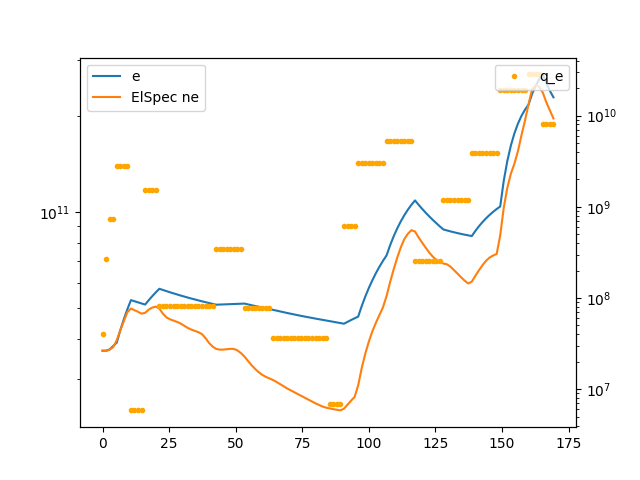

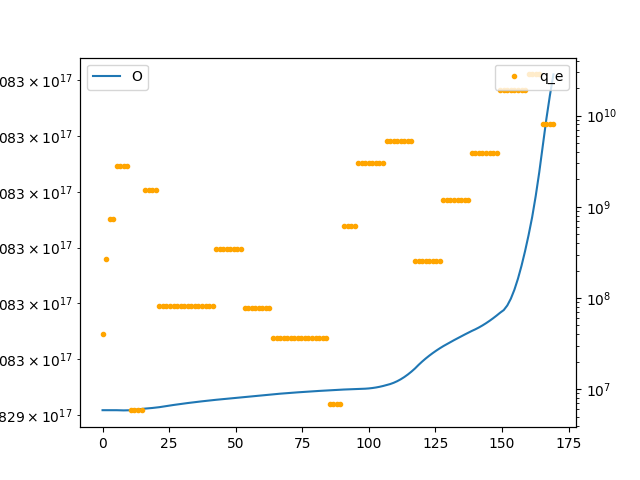

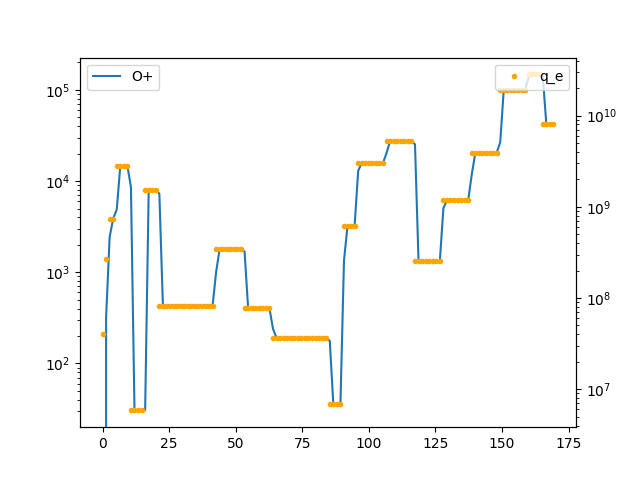

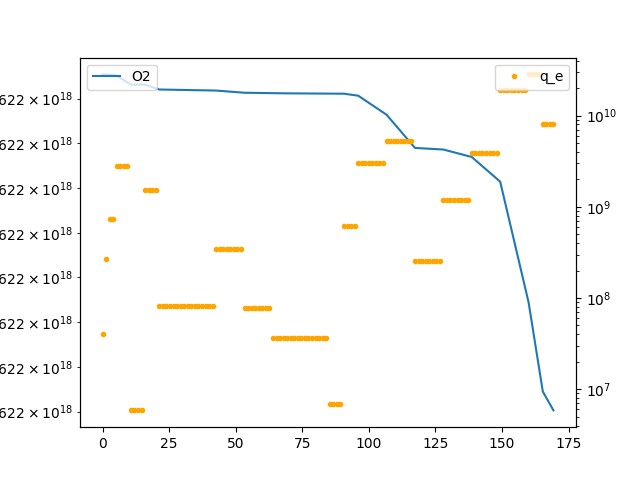

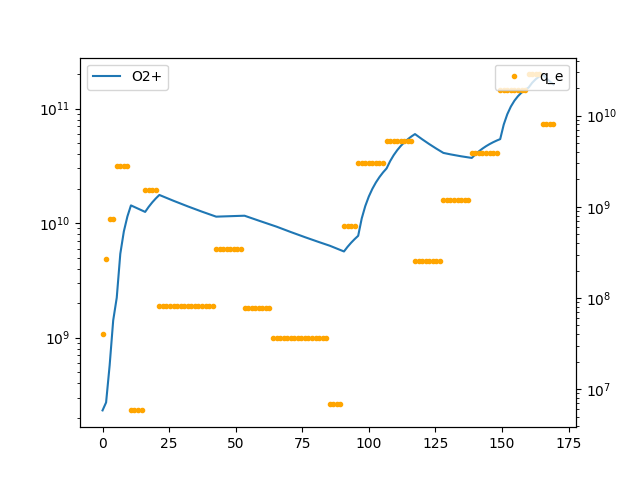

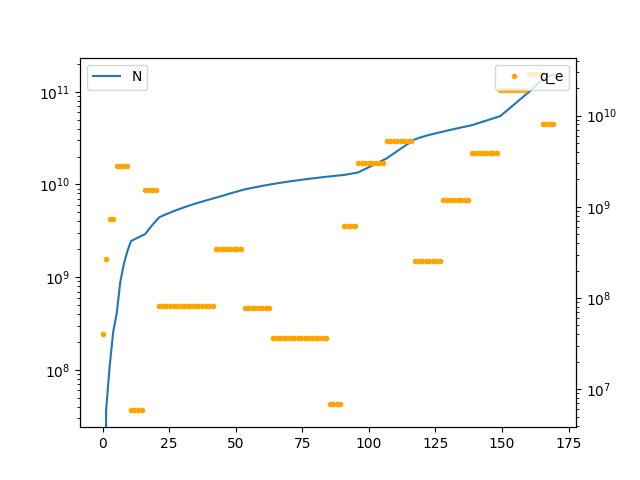

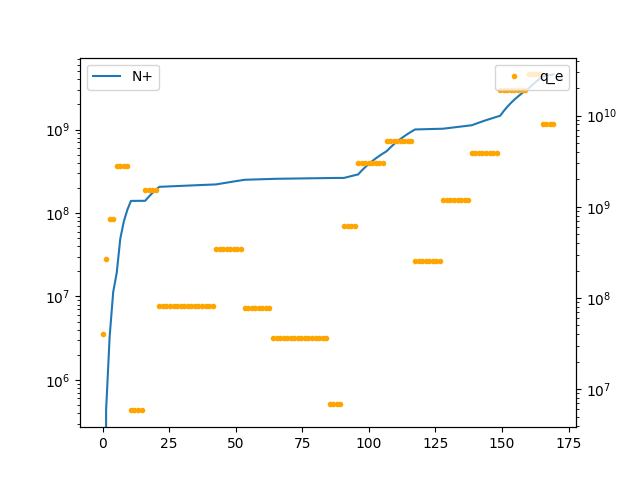

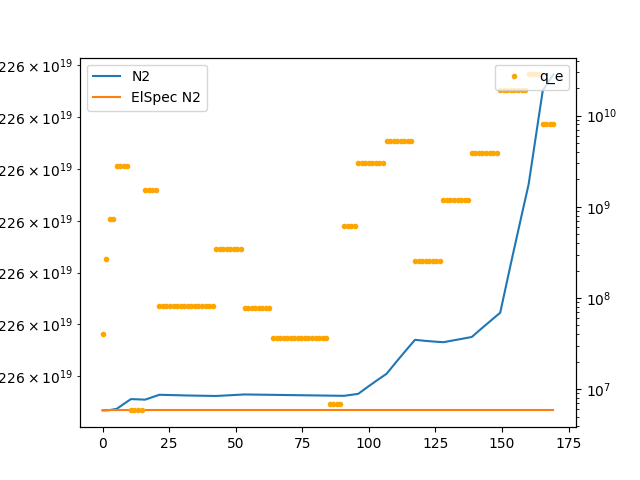

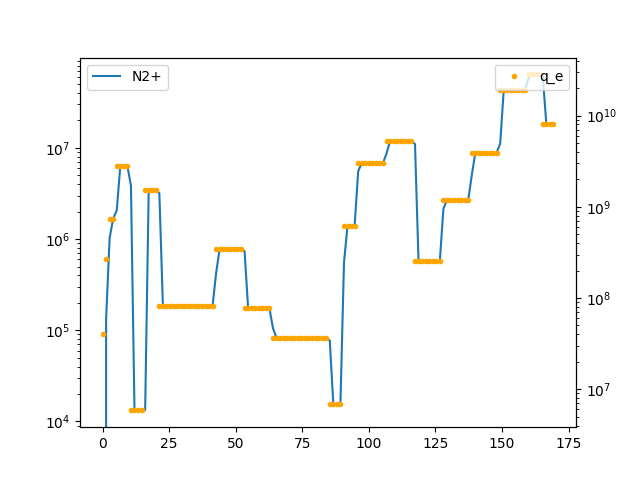

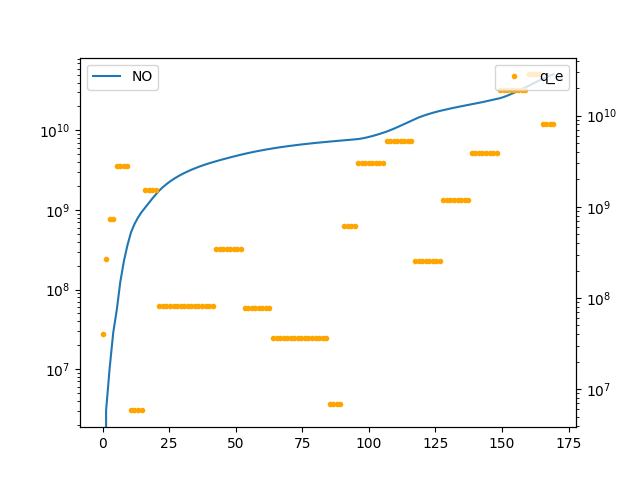

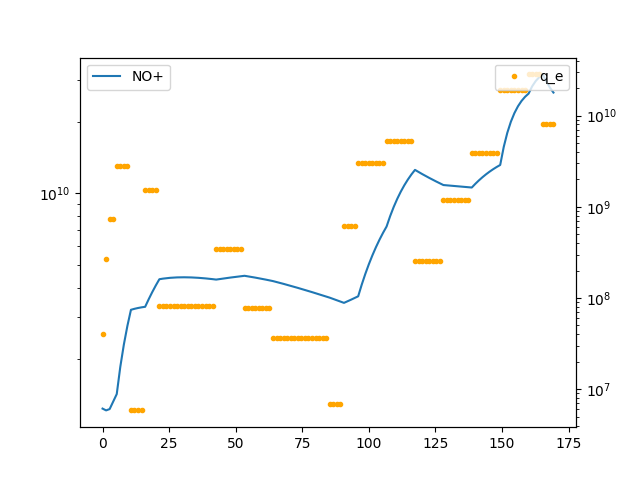

In [12]:
for h, i in enumerate(res):
    for c in model.all_species:
        plt.figure()
        plt.plot(i.t, i.y[c.c_ID, :], label = c.name)
        if c == model.e: plt.plot(ts, con["ne"][h, :], label = 'ElSpec ne')
        if c == model.N2: plt.plot(ts, con["iri"][h, 3], label = 'ElSpec N2')
        plt.legend(loc = 2)
        plt.yscale('log')
        ax2 = plt.gca().twinx()
        ax2.plot(ts, e_prod[:, 0], '.', color = 'orange', label = 'q_e')
        ax2.set_yscale('log')
        ax2.legend(loc = 1)
        #for t in ts: plt.axvline(t, alpha = 0.1)
    break

In [13]:
res[0].y.shape

elspec_iri_ICsorted = np.array([r.y for r in res])

print(elspec_iri_ICsorted.shape)
print(rrate.T.shape)

eff_rr = (rrate.T[:, 0, :]*elspec_iri_ICsorted[:, 10, :] + \
          rrate.T[:, 1, :]*elspec_iri_ICsorted[:, 4 , :] + \
          rrate.T[:, 2, :]*elspec_iri_ICsorted[:, 6 , :]   ) / elspec_iri_ICsorted[:, 0, :]
print(eff_rr.shape)
print(eff_rr)
#print(con["alpha"])

#elspec_iri_sorted = 


mdict = {"elspec_iri_ICsorted": elspec_iri_ICsorted, "eff_rr": eff_rr}
spio.savemat(direc + 'IC.mat', mdict)

with open(direc + 'IC_iri.txt', 'w') as f:
    np.savetxt(f, elspec_iri_ICsorted.reshape(-1))

with open(direc + 'IC_effrr.txt', 'w') as f:
    np.savetxt(f, eff_rr.reshape(-1))

(62, 11, 128)
(62, 12, 128)
(62, 128)
[[1.91379544e-14 1.92003432e-14 2.19784463e-14 ... 3.05042801e-13
  3.02282060e-13 2.99829938e-13]
 [1.15302086e-14 1.13259315e-14 1.25418609e-14 ... 2.86607962e-13
  2.81619271e-13 2.77349702e-13]
 [7.57679098e-15 7.23305751e-15 7.70557058e-15 ... 2.65556947e-13
  2.58388848e-13 2.52527496e-13]
 ...
 [7.09041482e-16 6.97885756e-16 6.74754456e-16 ... 9.90854746e-14
  9.73944683e-14 9.60016944e-14]
 [7.53738931e-16 7.43898357e-16 7.20424335e-16 ... 1.00164254e-13
  9.84085802e-14 9.69585653e-14]
 [8.00907203e-16 7.91849690e-16 7.67978908e-16 ... 1.01070588e-13
  9.92672063e-14 9.77755860e-14]]


In [ ]:

def ic():
    res = np.empty(model.n_heights, dtype = 'object')
    
    for h in range(model.n_heights):
        n = np.array([c.density[h] for c in model.all_species])
        res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h], t_eval = ts, max_step = 0.0444)
#        res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h], t_eval = np.arange(0, te[-1], 0.01), max_step = 0.0444)
        #for j, c in enumerate(model.all_species):
        #    c.density[h] = res[h].y[j, -1]           #replaced by below code:
    
    new_densities = np.array([alt.y[:, -1] for alt in res]).T
    #return new_densities
    return res

import time
st = time.time()
res = ic()
print(time.time()-st)

In [ ]:
for i in res:
    for c in model.all_species:
        plt.figure()
        plt.plot(i.t, i.y[c.c_ID, :], label = c.name)
        if c == model.e: plt.plot(ts, con["ne"][0, :], label = 'ElSpec ne')
        plt.legend(loc = 2)
        plt.yscale('log')
        ax2 = plt.gca().twinx()
        ax2.plot(ts, e_prod[:, 0], '.', color = 'orange', label = 'q_e')
        ax2.set_yscale('log')
        ax2.legend(loc = 1)
        #for t in ts: plt.axvline(t, alpha = 0.1)
    break

In [14]:
print(elspec_iri_ICsorted.shape)

(62, 11, 128)


In [18]:
print(elspec_iri_ICsorted.swapaxes(0, 1).shape)

(11, 62, 128)


In [17]:
elspec_iri_ICsorted[:, 0, :] == elspec_iri_ICsorted.swapaxes(0, 1)[0, :, :]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [22]:
[e,
O,
Op,
O2,
O2p,
N,
Np,
N2,
N2p,
NO,
NOp] = elspec_iri_ICsorted.swapaxes(0, 1)

In [27]:
[Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model.swapaxes(0, 1)

[e,
O,
Op,
O2,
O2p,
N,
Np,
N2,
N2p,
NO,
NOp] = elspec_iri_ICsorted.swapaxes(0, 1)

elspec_iri_sorted = np.array([Tn,Ti,Te,nN2,nO2,nO,nAr,NOp,O2p,Op]).swapaxes(0, 1)
elspec_iri_sorted.shape

(62, 10, 128)

In [23]:
e.shape

(62, 128)

In [24]:
n_model.shape

(62, 10, 128)

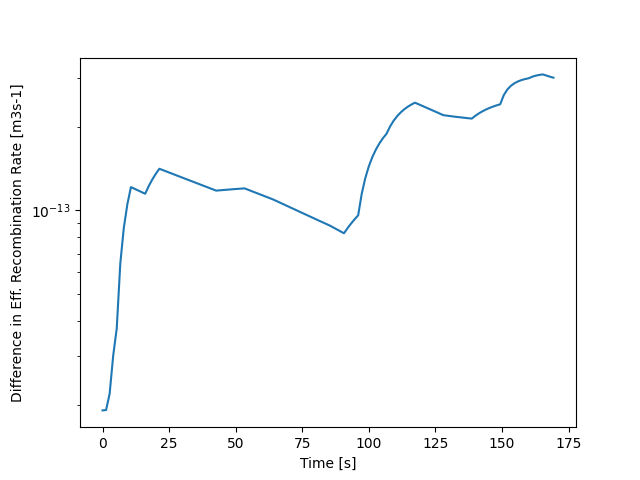

In [29]:
plt.figure()
plt.plot(ts, eff_rr[0, :])
plt.xlabel('Time [s]')
plt.ylabel('Difference in Eff. Recombination Rate [m3s-1]')
plt.yscale('log')


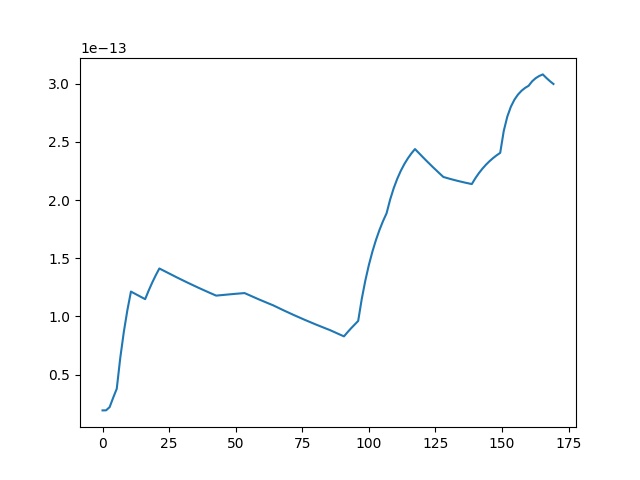

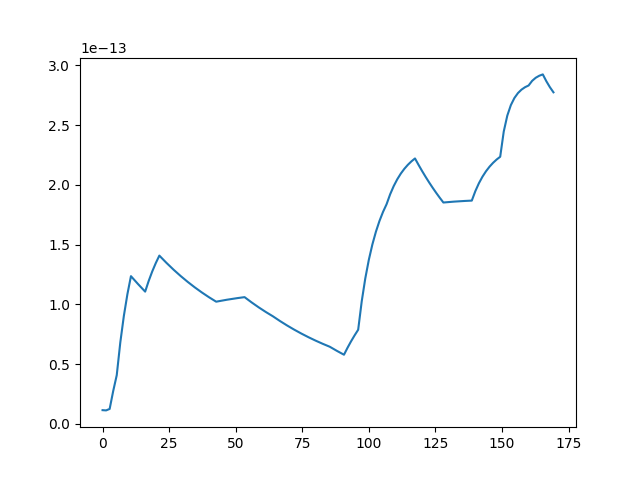

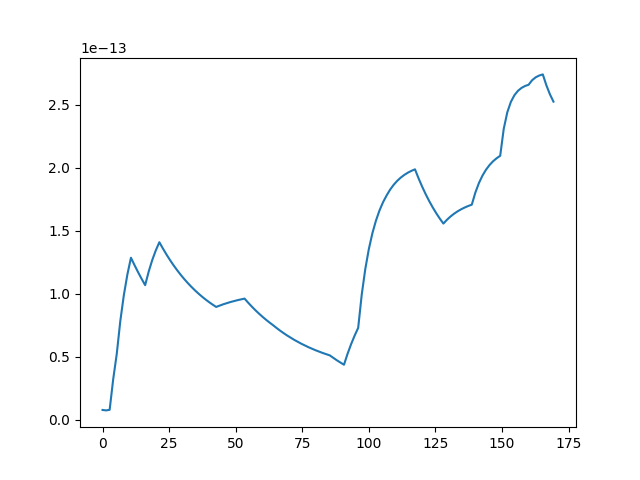

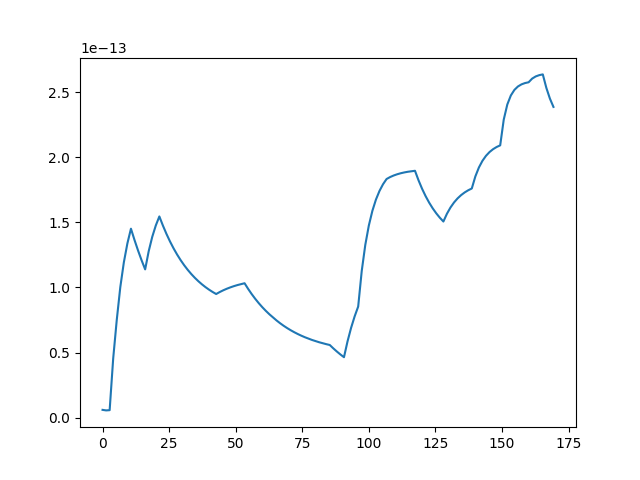

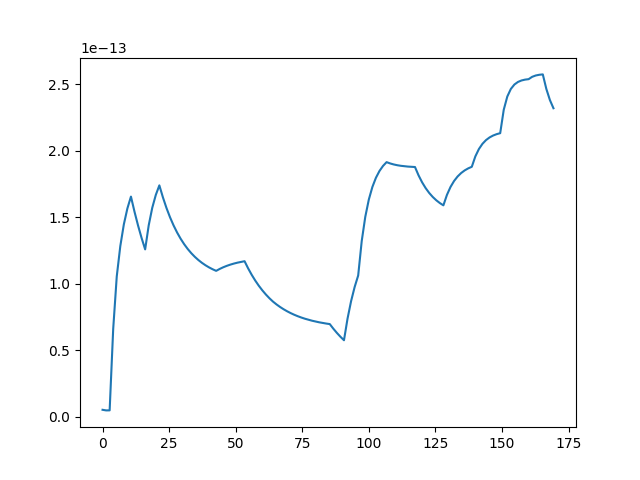

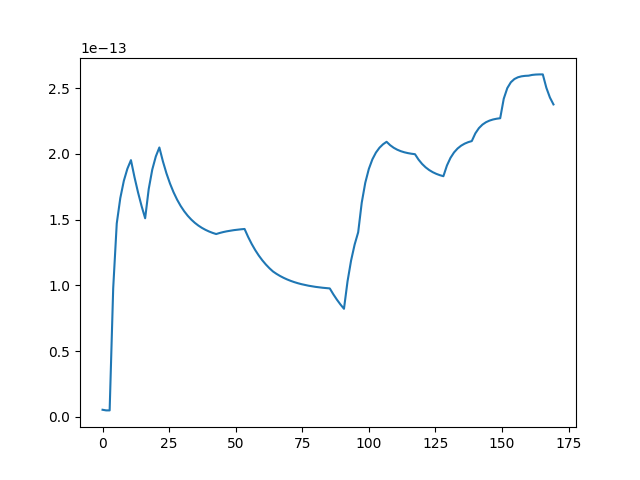

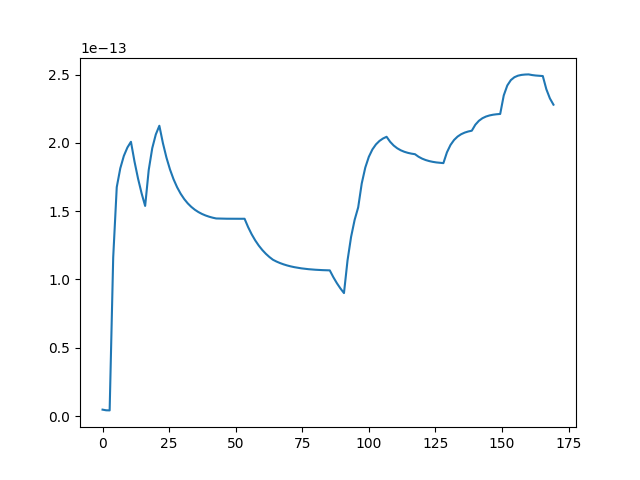

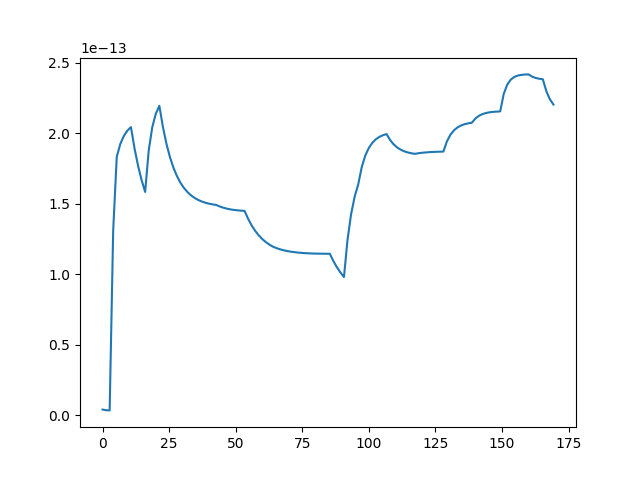

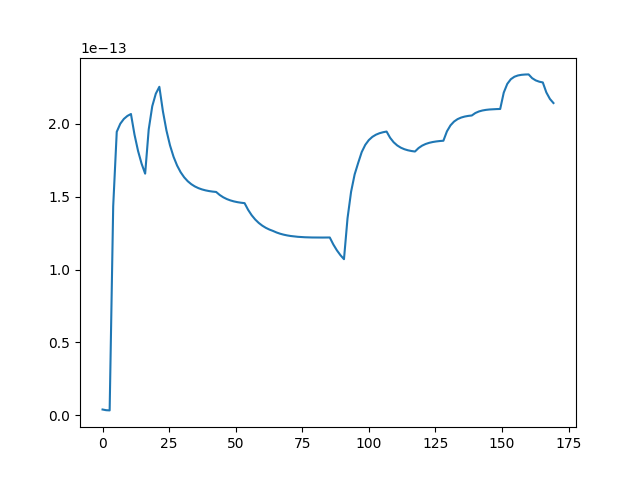

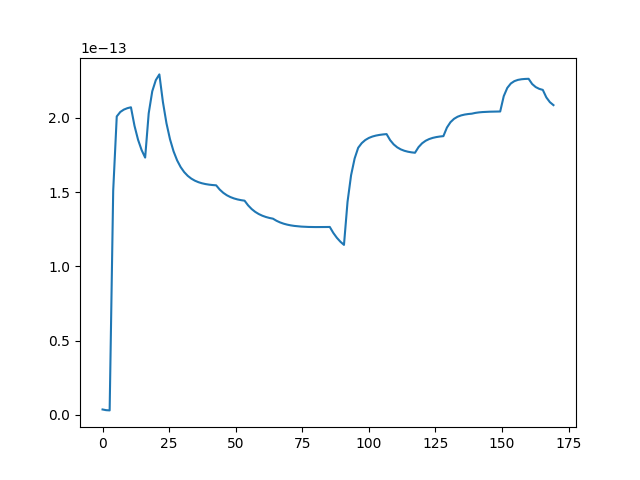

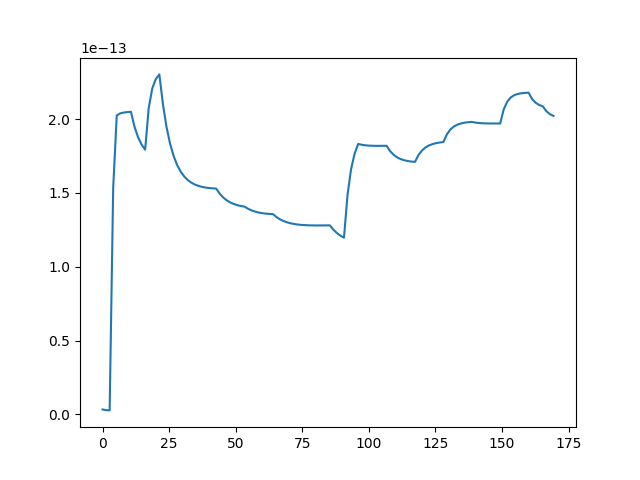

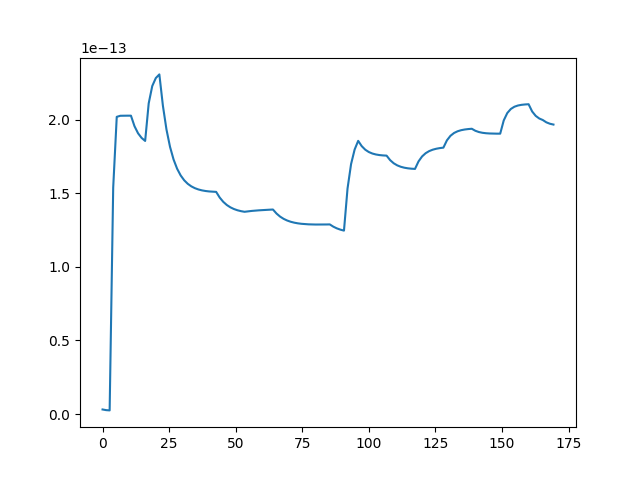

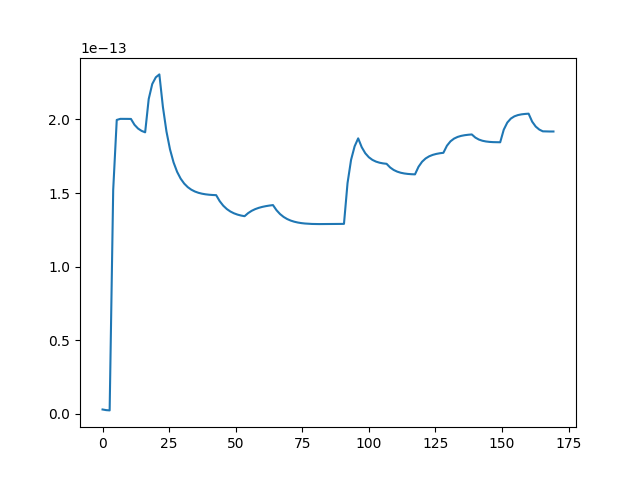

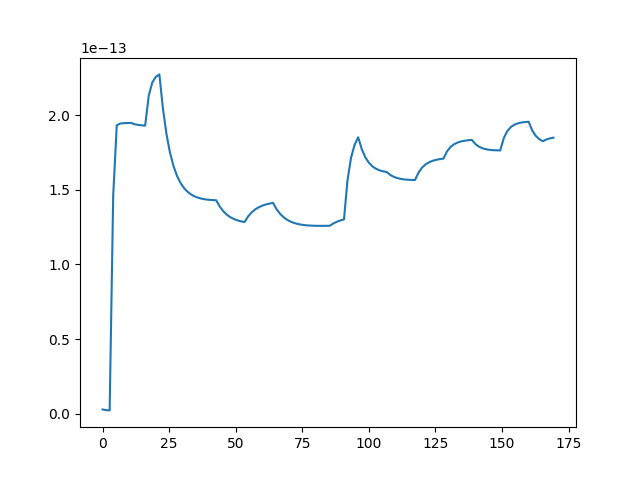

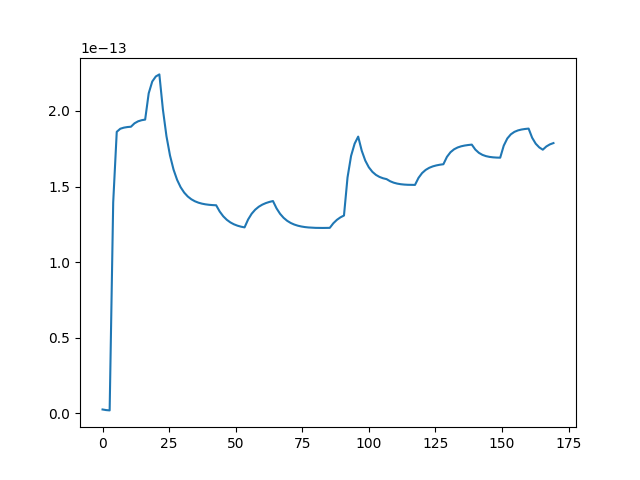

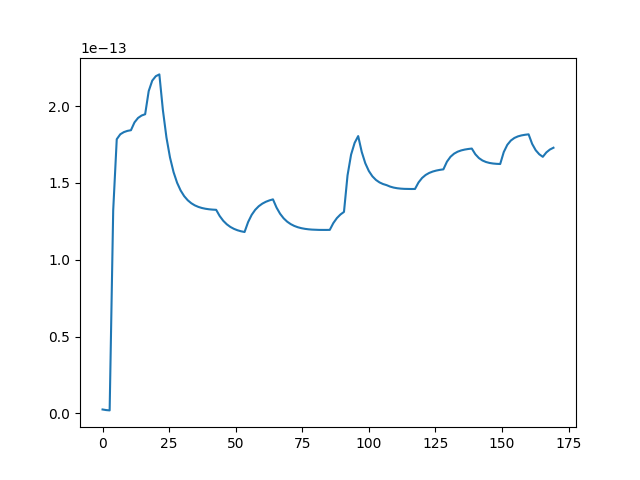

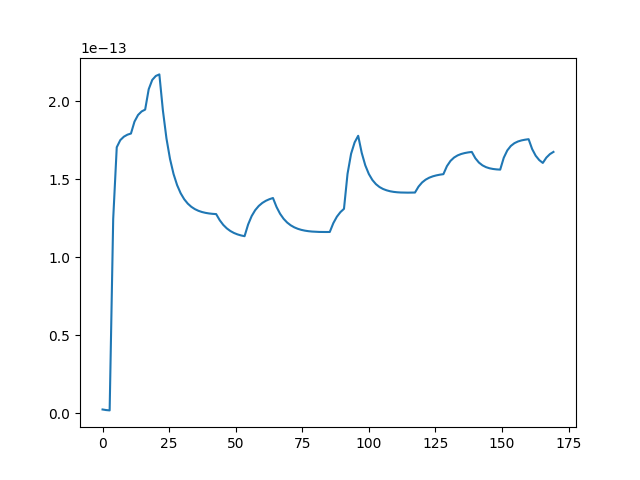

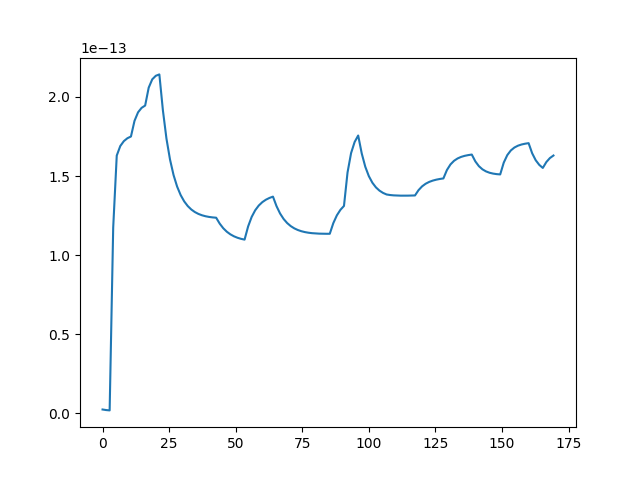

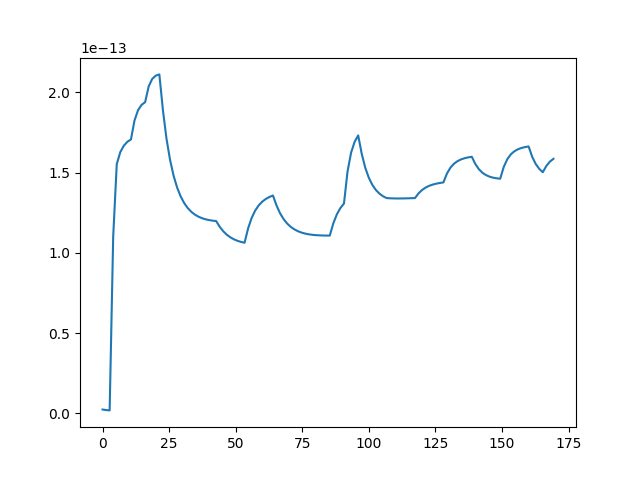

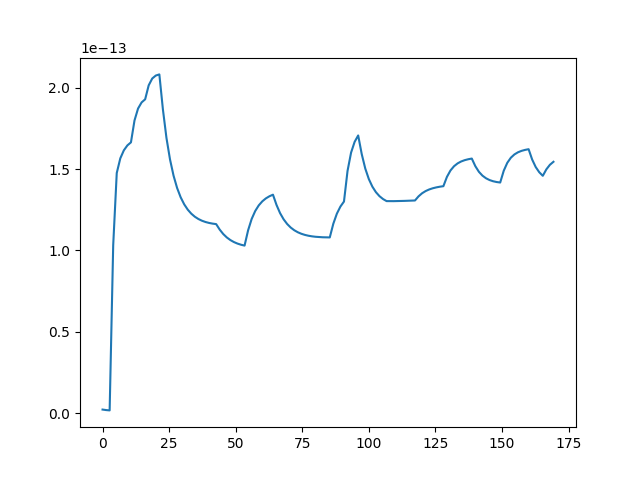

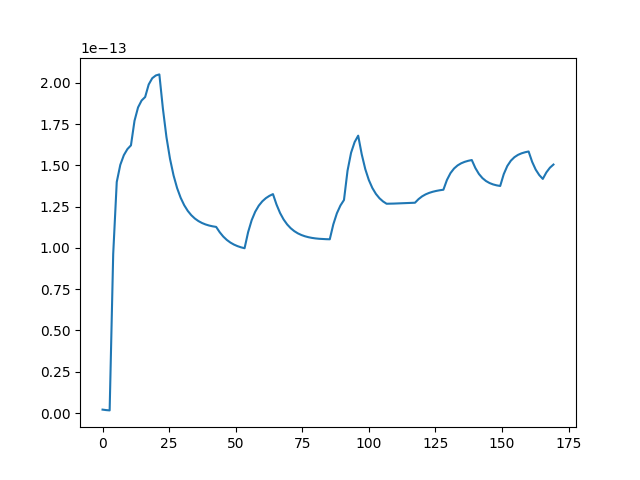

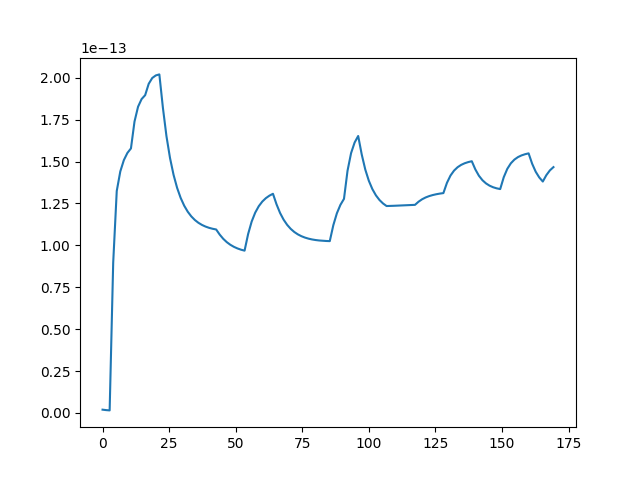

In [30]:
for i in range(22):
    plt.figure()
    plt.plot(ts, eff_rr[i, :])